In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import amlrealtimeai
from amlrealtimeai import resnet50

import h5py

In [2]:
# Input images as a two-dimensional tensor containing an arbitrary number of images represented a strings
import amlrealtimeai.resnet50.utils
in_images = tf.placeholder(tf.string)
image_tensors = resnet50.utils.preprocess_array(in_images)
image_tensors = tf.placeholder(tf.int32,shape=(None,224, 224, 3))

In [3]:
subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
model_management_account = "CMS_FPGA_1"

from amlrealtimeai.resnet50.model import RemoteQuantizedResNet50
model_path = os.path.expanduser('~/models')
featurizer = RemoteQuantizedResNet50(subscription_id, resource_group, model_management_account, model_path)
print(featurizer.version)

Using TensorFlow backend.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code E6ND4QG9H to authenticate.
1.1.6-rc


In [4]:
featurizer.import_graph_def(include_top=False, input_tensor=image_tensors)
features = featurizer.featurizer_output

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load MNIST
f = h5py.File("//Users/atsaris/mygit_repos/ml_service/datasets/RandomData/hdf5/mnist_test.hdf5",'r')
images = np.array(f['features'])
images = images.reshape(images.shape[0], images.shape[2], images.shape[3], images.shape[1])/255.
#print(images[0,:,:,-1].shape)
#plt.imshow(images[0,:,:,-1])
labels = np.array(f['targets'])
labels = labels.reshape(labels.shape[0])
f.close()

NUMBER_OF_DATA = 500

# Reshape the image
images = images[:NUMBER_OF_DATA]
sess = tf.Session()
with sess.as_default():
    images_tf = tf.image.grayscale_to_rgb(images)
    images_tf = tf.image.resize_images(images_tf, [224,224])
    images = images_tf.eval()

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    
# Extract features
feature_list = []
with tf.Session() as sess:
    for chunk in tqdm(chunks(images,50)):
        print(chunk.shape)
        result= sess.run([features],feed_dict={image_tensors:chunk})
        feature_list.extend(result[0])

feature_results = np.array(feature_list)
print(feature_results.shape)

0it [00:00, ?it/s]

(50, 224, 224, 3)


1it [00:13, 13.02s/it]

(50, 224, 224, 3)


2it [00:18,  9.39s/it]

(50, 224, 224, 3)


3it [00:23,  7.83s/it]

(50, 224, 224, 3)


4it [00:29,  7.31s/it]

(50, 224, 224, 3)


5it [00:34,  6.92s/it]

(50, 224, 224, 3)


6it [00:38,  6.46s/it]

(50, 224, 224, 3)


7it [00:43,  6.26s/it]

(50, 224, 224, 3)


8it [00:49,  6.18s/it]

(50, 224, 224, 3)


9it [00:56,  6.31s/it]

(50, 224, 224, 3)


10it [01:03,  6.39s/it]

(500, 1, 1, 2048)


In [169]:
featurizer.cleanup_remote_service()

Deleting service 6052a6b9c57b412abc38ad93407c060c
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Deleted service 6052a6b9c57b412abc38ad93407c060c
Deleting model 7f1151ab419c4bb49037d8649de835a8
Deleted model 7f1151ab419c4bb49037d8649de835a8


In [7]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras import optimizers

FC_SIZE = 1024
NUM_CLASSES = 10

model = Sequential()
model.add(Dropout(0.2, input_shape=(1, 1, 2048,)))
model.add(Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,)))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='sigmoid', input_dim=FC_SIZE))

model.compile(optimizer=optimizers.SGD(lr=1e-4,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

onehot_labels = np_utils.to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(feature_results, onehot_labels[:NUMBER_OF_DATA], random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(375, 1, 1, 2048) (125, 1, 1, 2048) (375, 10) (125, 10)


In [9]:
model.fit(X_train, y_train, epochs=16, batch_size=32)

Epoch 1/16
375/375 [==============================] - 0s 755us/step - loss: 0.7368 - acc: 0.4485
Epoch 2/16
375/375 [==============================] - 0s 295us/step - loss: 0.6654 - acc: 0.5869
Epoch 3/16
375/375 [==============================] - 0s 306us/step - loss: 0.5883 - acc: 0.7576
Epoch 4/16
375/375 [==============================] - 0s 299us/step - loss: 0.5290 - acc: 0.8483
Epoch 5/16
375/375 [==============================] - 0s 301us/step - loss: 0.4802 - acc: 0.8816
Epoch 6/16
375/375 [==============================] - 0s 312us/step - loss: 0.4490 - acc: 0.8896
Epoch 7/16
375/375 [==============================] - 0s 307us/step - loss: 0.4235 - acc: 0.8968
Epoch 8/16
375/375 [==============================] - 0s 310us/step - loss: 0.4092 - acc: 0.8973
Epoch 9/16
375/375 [==============================] - 0s 303us/step - loss: 0.3976 - acc: 0.8976
Epoch 10/16
375/375 [==============================] - 0s 310us/step - loss: 0.3852 - acc: 0.8984
Epoch 11/16
375/375 [========

In [10]:
from numpy import argmax

y_probs = model.predict(X_test)
y_prob_max = np.argmax(y_probs, 1)
y_test_max = np.argmax(y_test, 1)
print(y_probs)
print(y_prob_max)
print(y_test_max)

[[0.13513935 0.18531743 0.17258973 ... 0.13926761 0.15818997 0.159538  ]
 [0.13717546 0.19150513 0.1709317  ... 0.14096718 0.1603162  0.16302766]
 [0.13578951 0.18741485 0.17059045 ... 0.14084026 0.1563733  0.16019687]
 ...
 [0.1341301  0.19298194 0.17015353 ... 0.14222308 0.15411158 0.16140483]
 [0.13568588 0.16600095 0.17043592 ... 0.13720359 0.14801843 0.15030824]
 [0.13888523 0.18987575 0.16982716 ... 0.14215684 0.15686919 0.16649975]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1]
[6 9 8 5 9 9 1 7 3 3 9 0 5 8 2 1 8 3 6 3 0 5 2 5 3 6 4 5 0 3 4 9 0 3 1 5 1
 7 9 3 6 3 0 9 4 2 7 6 7 6 2 5 6 7 9 0 0 3 1 9 7 7 3 5 7 1 3 1 4 8 5 6 8 8
 5 4 8 0 1 8 1 2 2 2 2 3 1 9 0 2 3 6 2 0 8 5 7 7 7 5 2 5 4 9 1 4 7 7 2 5 1
 2 3 0 3 9 4 2 4 4 7 1 9 5 3]


/Users/atsaris/anaconda2/envs/amlrealtimeai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/atsaris/anaconda2/envs/amlrealtimeai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.104
Precision [0.         0.10655738 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Recall [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
F1 [0.         0.19259259 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Confusion Matrix [[0, 11, 0, 0, 0, 0, 0, 0, 0, 0], [0, 13, 0, 0, 0, 0, 0, 0, 0, 0], [0, 14, 0, 0, 0, 0, 0, 0, 0, 0], [1, 16, 0, 0, 0, 0, 0, 0, 0, 0], [0, 10, 0, 0, 0, 0, 0, 0, 0, 0], [0, 14, 1, 0, 0, 0, 0, 0, 0, 0], [0, 8, 1, 0, 0, 0, 0, 0, 0, 0], [0, 14, 0, 0, 0, 0, 0, 0, 0, 0], [0, 9, 0, 0, 0, 0, 0, 0, 0, 0], [0, 13, 0, 0, 0, 0, 0, 0, 0, 0]]


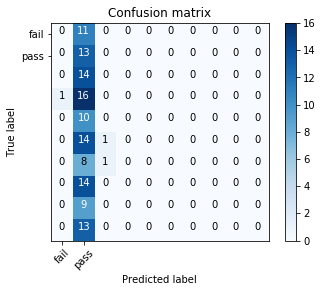

In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib
from matplotlib import pyplot as plt

# compute a bunch of classification metrics 
def classification_metrics(y_true, y_pred, y_prob):
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred, average=None)
    cm_dict['Recall'] =  recall_score(y_true, y_pred, average=None)
    cm_dict['F1'] =  f1_score(y_true, y_pred, average=None) 
    #cm_dict['AUC'] = roc_auc_score(y_true, y_prob[:,0])
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    New BSD License - see appendix
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_dict = classification_metrics(y_test_max, y_prob_max, y_probs)
for m in cm_dict:
    print(m, cm_dict[m])
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['fail','pass'], normalize=False)